# Libs and Functions

In [1]:
# coding: utf8

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, ifft

def chirp_signal(direction,BW,tp,fs):
    if(direction == 'upchirp'):
        K = BW/tp
    elif(direction == 'downchirp'):
        K = -BW/tp
    
    time = np.arange(-tp/2,tp/2,1/fs)
    
    chirp_out = np.exp(1j*(np.pi*K*time**2))
    return chirp_out

def fastconv(A,B):
    out_len = len(A)+len(B)-1
    
    # Next nearest power of 2
    sizefft = int(2**(np.ceil(np.log2(out_len))))
    
    Afilled = np.concatenate((A,np.zeros(sizefft-len(A))))
    Bfilled = np.concatenate((B,np.zeros(sizefft-len(B))))
    
    fftA = fft(Afilled)
    fftB = fft(Bfilled)
    
    fft_out = fftA * fftB
    out = ifft(fft_out)
    
    out = out[0:out_len]
    
    return out

def getRank(s):
    return (np.arange(len(s))*c/fs/2+(rmin))/1e3

def getTime(s):
    return 1/(fs*np.arange(len(s)))

# Parameters

In [2]:
c = 3e8 # speed of light [m/s]
fc = 1300e6 # Carrier freq
wlen = c/fc # Wavelength
fs = 10e6 # Sampling freq
Np = 10 # Intervalos de sampling

Te = 5e-6 # recovery Time 
Tp = 10e-6 # Pulse Width
BW = 2e6 # Chirp bandwidth
PRF = 1500 # Pulse repetition Frequency [Hz]

#rmax = 30e3 # max range [m]
#rmin = 3e3 # min range [m]
#rua = 27000
PRI = PRF**(-1) # Pulse repetition interval [s]
ru = (c*(PRI-Tp))/2 # Unambigous Range
rmin = (Tp+Te)*c/2 # 
vu = wlen*PRF/2
#T = 1e-5
#T_out = [2e-5, 2e-4]

# Target Info

In [3]:
Ntargets = 4 # Cantidad de Targets
ranges = [5000,10000,20000,25000] # Rango de target
SNR = [7, 10, 30,35] # SNR del target
vels = [43.26923077,86.53846154,-20.76923077,0] # Velocidad del target

# Read Signals

In [4]:
# Signals

df = pd.read_csv('signal.csv',index_col=None)
rxSignal = np.array(df['real']+1j*df['imag'])
rxSignal = rxSignal.reshape(Np,-1)

channel = pd.read_csv('channel.csv',index_col=None)
channel = np.array(channel['channel_real']+1j*channel['channel_imag'])

rmax = len(rxSignal[0])*c/fs/2

In [5]:
print(f'Pulse repetition Interval. PRI = {PRI*1e6:.2f} μs')
print(f'Unambiguous Range. Ru = {ru/1e3:.3f} km')
print(f'Unambiguous Velocity. Vu = {vu:.2f} m/s')
print(f'Minimum Range. Rmin = {rmin/1e3:.3f} km')
print(f'Maximum Range. Rmin = {rmax/1e3:.3f} km')

Pulse repetition Interval. PRI = 666.67 μs
Unambiguous Range. Ru = 98.500 km
Unambiguous Velocity. Vu = 173.08 m/s
Minimum Range. Rmin = 2.250 km
Maximum Range. Rmin = 27.015 km


29.25


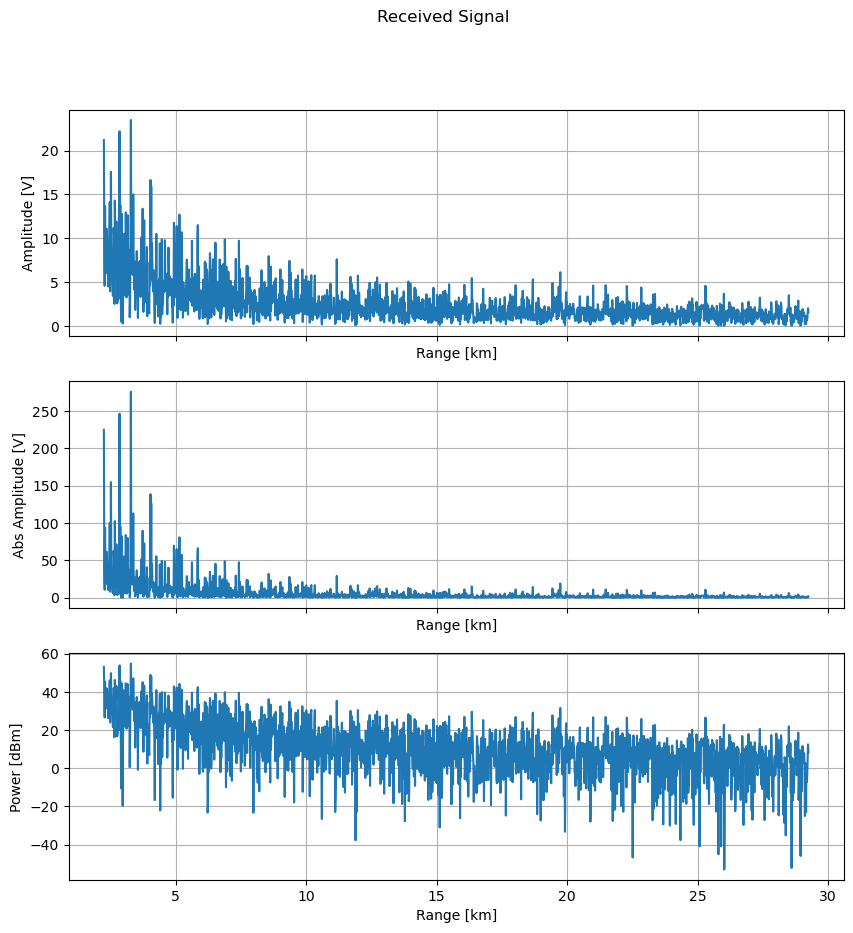

In [14]:
# Plot Signals

fig, axes = plt.subplots(3,1,figsize=(10,10),sharex=True)

print(getRank(rxSignal[0])[-1])

fig.suptitle('Received Signal')

ax = axes[0]
ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[0]))
ax.set_ylabel('Amplitude [V]')
ax.set_xlabel('Range [km]')
ax.grid(True)

ax = axes[1]
ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[0]**2)/2)
ax.set_ylabel('Abs Amplitude [V]')
ax.set_xlabel('Range [km]')
ax.grid(True)

ax = axes[2]
ax.plot(getRank(rxSignal[0]),20*np.log10(np.abs(rxSignal[0]**2)))
ax.set_ylabel('Power [dBm]')
ax.set_xlabel('Range [km]')
ax.grid(True)

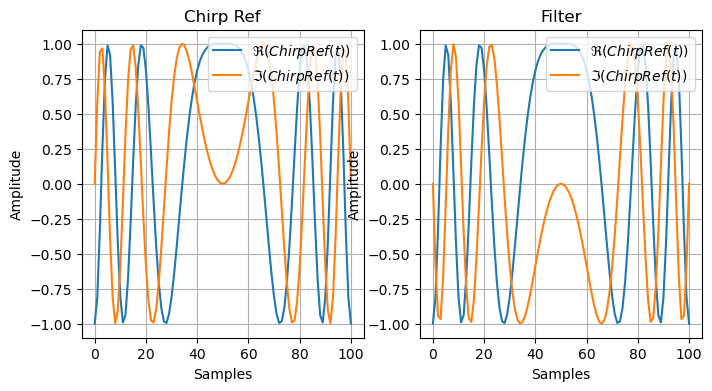

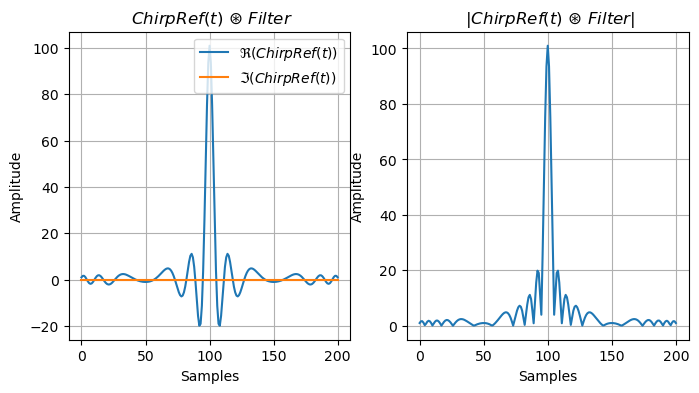

In [6]:
chirp_ref = chirp_signal('upchirp',BW,Tp,fs)
filtro = np.conj(np.flip(chirp_signal('upchirp',BW,Tp,fs)))

chirp_comp = fastconv(filtro,chirp_ref)

# Plots

fig, axes = plt.subplots(1,2,figsize=(8,4))

ax = axes[0]
ax.plot(chirp_ref.real,label=r'$\Re(Chirp Ref(t))$')
ax.plot(chirp_ref.imag,label=r'$\Im(Chirp Ref(t))$')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
ax.set_title('Chirp Ref')
ax.legend(loc='upper right')
ax.grid(True)

ax = axes[1]
ax.plot(filtro.real,label=r'$\Re(Chirp Ref(t))$')
ax.plot(filtro.imag,label=r'$\Im(Chirp Ref(t))$')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
ax.set_title('Filter')
ax.legend(loc='upper right')
ax.grid(True)

fig, axes = plt.subplots(1,2,figsize=(8,4))

ax = axes[0]
ax.plot(chirp_comp.real,label=r'$\Re(Chirp Ref(t))$')
ax.plot(chirp_comp.imag,label=r'$\Im(Chirp Ref(t))$')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
ax.set_title(r' $ChirpRef(t)~\circledast~Filter$')
ax.legend(loc='upper right')
ax.grid(True)

ax = axes[1]
ax.plot(np.abs(chirp_comp))
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
ax.set_title(r' $| ChirpRef(t)~\circledast~Filter|$')
ax.grid(True)

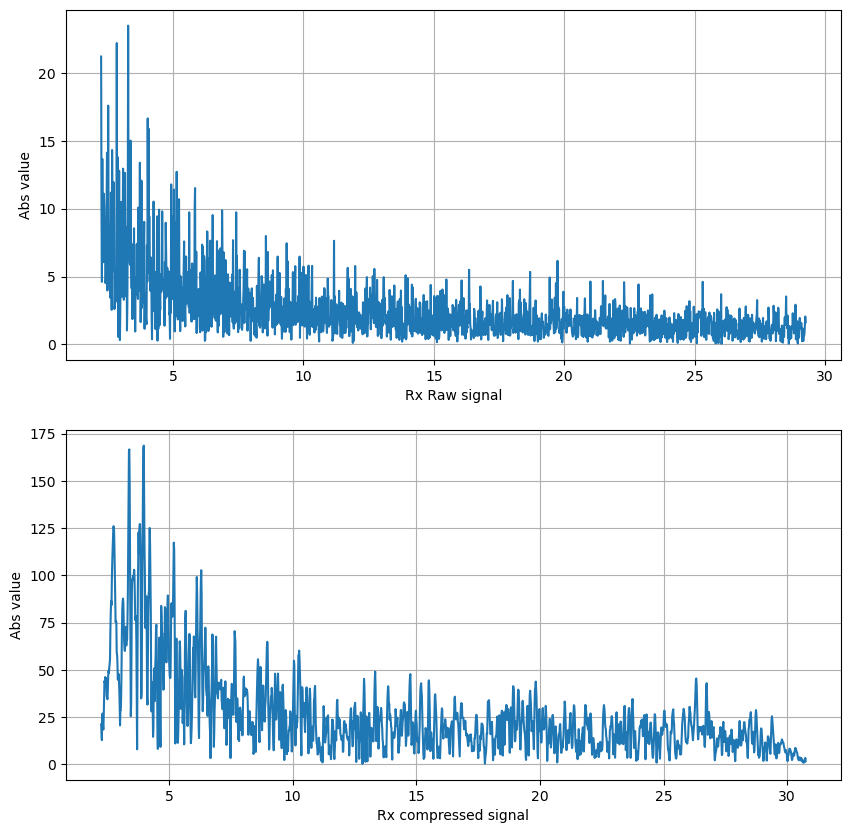

In [21]:
signal_comp = np.conj(fastconv(chirp_ref,rxSignal[0]))

fig, axes = plt.subplots(2,1,figsize=(10,10))

ax = axes[0]
ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[0]))
ax.set_ylabel('Abs value')
ax.set_xlabel('Rx Raw signal')
ax.grid(True)

ax = axes[1]
ax.plot(getRank(signal_comp),np.abs(signal_comp))
ax.set_ylabel('Abs value')
ax.set_xlabel('Rx compressed signal')
ax.grid(True)

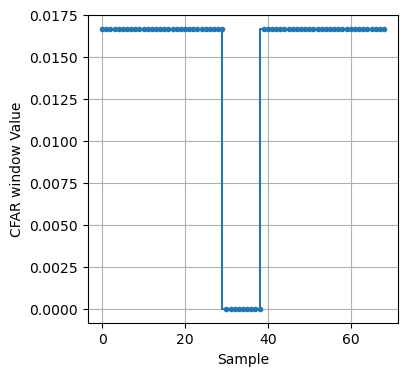

In [22]:
# ventana CFAR
n_gap = 4
n_ref = 30
v_ref = 1
h_cfar_gain = (1/(n_ref*2*v_ref))
h_cfar = np.concatenate((np.repeat(v_ref,n_ref),
                         np.repeat(0,n_gap*2+1),
                         np.repeat(v_ref,n_ref)))*h_cfar_gain

# Plot

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.step(range(len(h_cfar)),h_cfar,marker='.')
ax.set_xlabel('Sample')
ax.set_ylabel('CFAR window Value')
ax.grid(True)

# mti Simple cancelador

In [7]:

from ipywidgets import interact#, interactive,fixed,interact_manual
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_MTI_sc(gain_mti):
    signal_comp = []
    for t in range(len(rxSignal)):
        # convolucionar y quitar colas de convolucion
        comp = fastconv(rxSignal[t],filtro)[len(filtro)//2:len(rxSignal[t])+len(filtro)//2]
        signal_comp.append(comp)
    signal_comp = np.stack(signal_comp,axis=0)
    
    print(signal_comp.shape)
    
    # Se resta la segunda fila a la primera
    mti_matrix_sc = np.array([1,-1])
    cfar_mti_sc = np.inner(signal_comp[0:2].T,mti_matrix_sc)
    # convolucionar y quitar colas de convolucion
    th_cfar_mti_sc = gain_mti*fastconv(np.abs(cfar_mti_sc),h_cfar)
    print(len(h_cfar),len(th_cfar_mti_sc),len(cfar_mti_sc))
    th_cfar_mti_sc = th_cfar_mti_sc[len(h_cfar)//2:len(cfar_mti_sc)+len(h_cfar)//2]
    # Ver diferencias y targets
    dif_th_mti_sc = np.sign(np.abs(cfar_mti_sc) - np.abs(th_cfar_mti_sc))
    dif_th_mti_sc = np.diff(dif_th_mti_sc,n=1)
    targetsRank = getRank(dif_th_mti_sc)
    targetsRank = targetsRank[dif_th_mti_sc==2]
    
    print('Target loc [km]:\n',targetsRank)
    
    # Plot
    plt.clf()
    fig, axes = plt.subplots(5,1,figsize=(8,8))

    ax = axes[0]
    ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[0]),label='Rx $t_0$')
    ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[1]),label='Rx $t_1$')
    ax.set_title('Rx Raw signals')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[1]
    ax.plot(getRank(signal_comp[0]),np.abs(signal_comp[0]),label='Comp $t_0$')
    ax.plot(getRank(signal_comp[1]),np.abs(signal_comp[1]),label='Comp $t_0$')
    ax.set_title('Rx compressed signals')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[2]
    ax.plot(getRank(cfar_mti_sc),np.abs(cfar_mti_sc),label='MTI Signal')
    ax.plot(getRank(th_cfar_mti_sc),np.abs(th_cfar_mti_sc),label='MTI Threshold')
    ax.set_title('MTI SC')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[3]
    ax.plot(getRank(dif_th_mti_sc),np.abs(dif_th_mti_sc))
    ax.set_title('MTI_SC signal')
    ax.set_ylabel('Value')
    ax.set_xlabel('Range [km]')
    ax.grid(True)
    ax = axes[4]
    ax.plot(getRank(cfar_mti_sc),np.abs(cfar_mti_sc),label='MTI Signal',marker='.')
    ax.plot(getRank(th_cfar_mti_sc),np.abs(th_cfar_mti_sc),label='MTI Threshold',marker='.')
    ax.set_title('MTI SC')
    ax.set_ylabel('Value')
    ax.set_xlim((4.5,5.5))
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.close()
    
    return fig
    

fig = interact(plot_MTI_sc,gain_mti=np.arange(1,5,1/64),continuous_update=True)
# (4,30) 3.203125

interactive(children=(Dropdown(description='gain_mti', options=(1.0, 1.015625, 1.03125, 1.046875, 1.0625, 1.07…

(10, 1801)


In [212]:
# sti Simple cancelador
from ipywidgets import interact#, interactive,fixed,interact_manual
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_sti_sc(gain_sti):
    signal_comp = []
    for t in range(len(rxSignal)):
        # convolucionar y quitar colas de convolucion
        comp = fastconv(rxSignal[t],filtro)[len(filtro)//2:len(rxSignal[t])+len(filtro)//2]
        signal_comp.append(comp)
    signal_comp = np.stack(signal_comp,axis=0)
    
    print(signal_comp.shape)
    
    # Se resta la segunda fila a la primera
    sti_matrix_sc = np.array([1,1])
    cfar_sti_sc = np.inner(signal_comp[0:2].T,sti_matrix_sc)
    # convolucionar y quitar colas de convolucion
    th_cfar_sti_sc = gain_sti*fastconv(np.abs(cfar_sti_sc),h_cfar)
    print(len(h_cfar),len(th_cfar_sti_sc),len(cfar_sti_sc))
    th_cfar_sti_sc = th_cfar_sti_sc[len(h_cfar)//2:len(cfar_sti_sc)+len(h_cfar)//2]
    # Ver diferencias y targets
    dif_th_sti_sc = np.sign(np.abs(cfar_sti_sc) - np.abs(th_cfar_sti_sc))
    dif_th_sti_sc = np.diff(dif_th_sti_sc,n=1)
    targetsRank = getRank(dif_th_sti_sc)
    targetsRank = targetsRank[dif_th_sti_sc==2]
    
    print('Target loc [km]:\n',targetsRank)
    
    # Plot
    plt.clf()
    fig, axes = plt.subplots(5,1,figsize=(8,8))

    ax = axes[0]
    ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[0]),label='Rx $t_0$')
    ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[1]),label='Rx $t_1$')
    ax.set_title('Rx Raw signals')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[1]
    ax.plot(getRank(signal_comp[0]),np.abs(signal_comp[0]),label='Comp $t_0$')
    ax.plot(getRank(signal_comp[1]),np.abs(signal_comp[1]),label='Comp $t_0$')
    ax.set_title('Rx compressed signals')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[2]
    ax.plot(getRank(cfar_sti_sc),np.abs(cfar_sti_sc),label='sti Signal')
    ax.plot(getRank(th_cfar_sti_sc),np.abs(th_cfar_sti_sc),label='sti Threshold')
    ax.set_title('sti SC')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[3]
    ax.plot(getRank(dif_th_sti_sc),np.abs(dif_th_sti_sc))
    ax.set_title('sti_SC signal')
    ax.set_ylabel('Value')
    ax.set_xlabel('Range [km]')
    ax.grid(True)
    ax = axes[4]
    ax.plot(getRank(cfar_sti_sc),np.abs(cfar_sti_sc),label='sti Signal',marker='.')
    ax.plot(getRank(th_cfar_sti_sc),np.abs(th_cfar_sti_sc),label='sti Threshold',marker='.')
    ax.set_title('sti SC')
    ax.set_ylabel('Value')
    ax.set_xlim((4.5,5.5))
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.close()
    
    return fig
    

fig = interact(plot_sti_sc,gain_sti=np.arange(1,5,1/64),continuous_update=True)
# (4,30) 4.90625

interactive(children=(Dropdown(description='gain_sti', options=(1.0, 1.015625, 1.03125, 1.046875, 1.0625, 1.07…

In [214]:
# mti Doble cancelador
from ipywidgets import interact#, interactive,fixed,interact_manual
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_MTI_sc(gain_mti):
    signal_comp = []
    for t in range(len(rxSignal)):
        # convolucionar y quitar colas de convolucion
        comp = fastconv(rxSignal[t],filtro)[len(filtro)//2:len(rxSignal[t])+len(filtro)//2]
        signal_comp.append(comp)
    signal_comp = np.stack(signal_comp,axis=0)
    
    print(signal_comp.shape)
    
    # Se resta la segunda fila a la primera y a la tercera
    mti_matrix_sc = np.array([1,-2, 1])
    cfar_mti_sc = np.inner(signal_comp[0:3].T,mti_matrix_sc)
    # convolucionar y quitar colas de convolucion
    th_cfar_mti_sc = gain_mti*fastconv(np.abs(cfar_mti_sc),h_cfar)
    print(len(h_cfar),len(th_cfar_mti_sc),len(cfar_mti_sc))
    th_cfar_mti_sc = th_cfar_mti_sc[len(h_cfar)//2:len(cfar_mti_sc)+len(h_cfar)//2]
    # Ver diferencias y targets
    dif_th_mti_sc = np.sign(np.abs(cfar_mti_sc) - np.abs(th_cfar_mti_sc))
    dif_th_mti_sc = np.diff(dif_th_mti_sc,n=1)
    targetsRank = getRank(dif_th_mti_sc)
    targetsRank = targetsRank[dif_th_mti_sc==2]
    
    print('Target loc [km]:\n',targetsRank)
    
    # Plot
    plt.clf()
    fig, axes = plt.subplots(5,1,figsize=(8,8))

    ax = axes[0]
    ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[0]),label='Rx $t_0$')
    ax.plot(getRank(rxSignal[0]),np.abs(rxSignal[1]),label='Rx $t_1$')
    ax.set_title('Rx Raw signals')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[1]
    ax.plot(getRank(signal_comp[0]),np.abs(signal_comp[0]),label='Comp $t_0$')
    ax.plot(getRank(signal_comp[1]),np.abs(signal_comp[1]),label='Comp $t_0$')
    ax.set_title('Rx compressed signals')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[2]
    ax.plot(getRank(cfar_mti_sc),np.abs(cfar_mti_sc),label='MTI Signal')
    ax.plot(getRank(th_cfar_mti_sc),np.abs(th_cfar_mti_sc),label='MTI Threshold')
    ax.set_title('MTI SC')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax = axes[3]
    ax.plot(getRank(dif_th_mti_sc),np.abs(dif_th_mti_sc))
    ax.set_title('MTI_SC signal')
    ax.set_ylabel('Value')
    ax.set_xlabel('Range [km]')
    ax.grid(True)
    ax = axes[4]
    ax.plot(getRank(cfar_mti_sc),np.abs(cfar_mti_sc),label='MTI Signal',marker='.')
    ax.plot(getRank(th_cfar_mti_sc),np.abs(th_cfar_mti_sc),label='MTI Threshold',marker='.')
    ax.set_title('MTI SC')
    ax.set_ylabel('Value')
    ax.set_xlim((4.5,5.5))
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.close()
    
    return fig
    

fig = interact(plot_MTI_sc,gain_mti=np.arange(1,5,1/64),continuous_update=True)
# (4,30) 3.828125

interactive(children=(Dropdown(description='gain_mti', options=(1.0, 1.015625, 1.03125, 1.046875, 1.0625, 1.07…